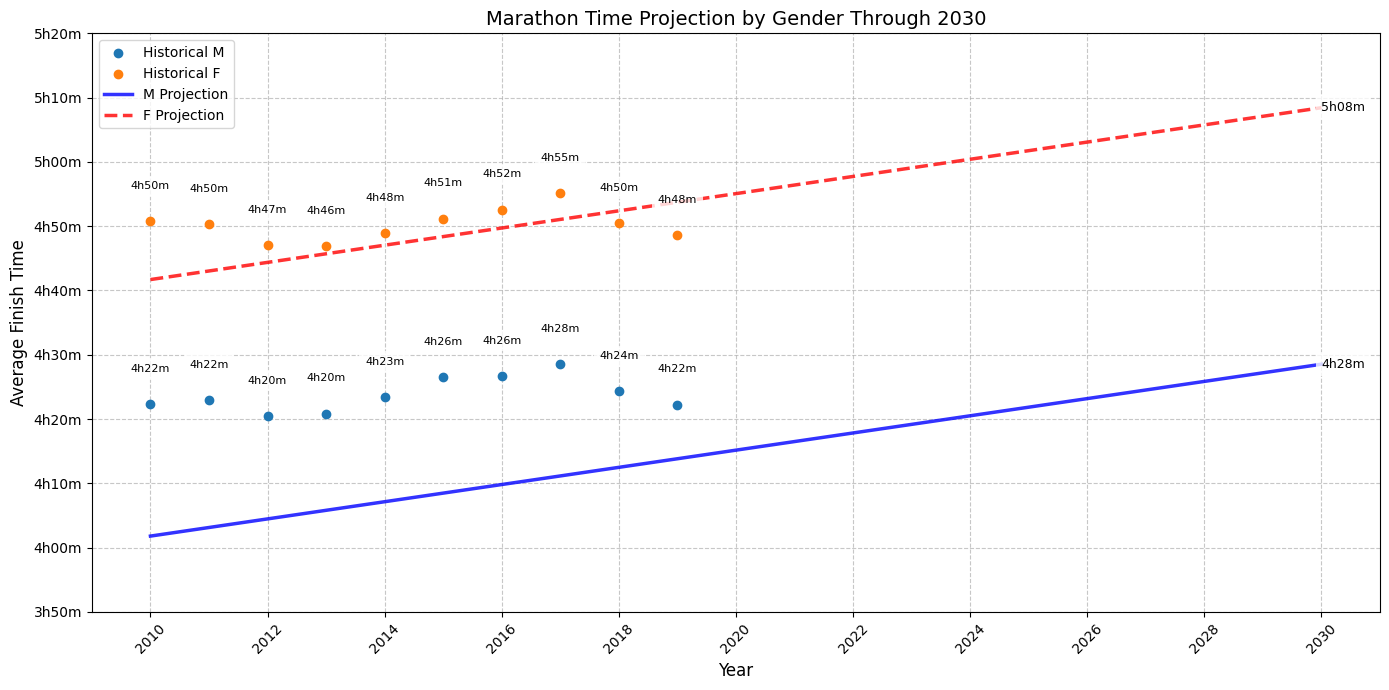


Future Projections:
Gender       F       M
Year                  
2020    4h 55m  4h 15m
2021    4h 56m  4h 16m
2022    4h 57m  4h 17m
2023    4h 59m  4h 19m
2024     5h 0m  4h 20m
2025     5h 1m  4h 21m
2026     5h 3m  4h 23m
2027     5h 4m  4h 24m
2028     5h 5m  4h 25m
2029     5h 7m  4h 27m
2030     5h 8m  4h 28m

Model Performance Metrics:
R² score: 0.977 (1.0 is perfect)
Mean Absolute Error: 1.64 minutes


In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and clean data
df = pd.read_csv('/Users/megantrapanese/Dropbox/MARATHON_DATA/data/2019_Fall_Results/Results.csv')
df = df.dropna(subset=['Year', 'Finish', 'Age', 'Gender'])  # Now including Gender

# Handle negative ages
mean_age = int(df[df['Age'] >= 0]['Age'].mean())
df.loc[df['Age'] < 0, 'Age'] = mean_age

# Convert finish time to minutes
df['Finish_Mins'] = df['Finish'] / 60

# Aggregate by Year, Gender, and Age - FIXED VERSION
yearly_gender_avg = df.groupby(['Year', 'Gender'])[['Finish_Mins', 'Age']].mean().reset_index()

# Create modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('gender', OneHotEncoder(), ['Gender'])  # Convert gender to numerical
    ],
    remainder='passthrough'  # Keep Year and Age as-is
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare data
X = yearly_gender_avg[['Year', 'Age', 'Gender']]
y = yearly_gender_avg['Finish_Mins']

# Train model
model.fit(X, y)

# Predict for future years (2020-2030)
last_year = yearly_gender_avg['Year'].max()
last_age = yearly_gender_avg['Age'].mean()  # Average of last year's genders

future_years = np.arange(last_year + 1, 2031)
future_ages = last_age + 0.5 * (future_years - last_year)

# Create future DataFrames for both genders
future_data = pd.DataFrame({
    'Year': np.tile(future_years, 2),
    'Age': np.tile(future_ages, 2),
    'Gender': ['M']*len(future_years) + ['F']*len(future_years)
})

# Make predictions
future_predictions = model.predict(future_data)
future_data['Predicted_Mins'] = future_predictions

# Generate predictions for historical data too
historical_predictions = model.predict(X)
yearly_gender_avg['Predicted_Mins'] = historical_predictions

# [Previous code remains the same until the plotting section]

# Create the plot
plt.figure(figsize=(14, 7))

# Convert minutes to hours:minutes for display
def mins_to_hh_mm(mins):
    hours = int(mins // 60)
    minutes = int(mins % 60)
    return f"{hours}h{minutes:02d}m"

# Plot historical data points
for gender in ['M', 'F']:
    mask = yearly_gender_avg['Gender'] == gender
    plt.scatter(yearly_gender_avg.loc[mask, 'Year'],
                yearly_gender_avg.loc[mask, 'Finish_Mins'],
                label=f'Historical {gender}', zorder=3)

# Plot regression lines with enhanced styling
for gender in ['M', 'F']:
    # Historical + future years
    all_years = np.concatenate([yearly_gender_avg['Year'].unique(), future_years])

    # Create prediction data for this gender
    pred_data = pd.DataFrame({
        'Year': all_years,
        'Age': last_age + 0.5 * (all_years - last_year),
        'Gender': gender
    })
    preds = model.predict(pred_data)

    # Plot line with different styles and colors
    line_style = '-' if gender == 'M' else '--'
    line_color = 'blue' if gender == 'M' else 'red'
    plt.plot(all_years, preds,
             label=f'{gender} Projection',
             linestyle=line_style,
             color=line_color,
             linewidth=2.5,
             alpha=0.8)

# Add formatting
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Finish Time', fontsize=12)
plt.title('Marathon Time Projection by Gender Through 2030', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(min(yearly_gender_avg['Year']), 2031, 2), rotation=45)

# Change y-axis to show hours:minutes format
current_yticks = plt.yticks()[0]
plt.yticks(current_yticks, [mins_to_hh_mm(m) for m in current_yticks])

# Add data labels in hours:minutes format
for _, row in yearly_gender_avg.iterrows():
    plt.text(row['Year'], row['Finish_Mins']+5,  # Slightly offset labels
             mins_to_hh_mm(row['Finish_Mins']),
             ha='center', fontsize=8,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Add projection labels for the last predicted year (2030)
for gender in ['M', 'F']:
    last_pred = future_data[(future_data['Year'] == 2030) & (future_data['Gender'] == gender)]
    if not last_pred.empty:
        pred_mins = last_pred['Predicted_Mins'].values[0]
        plt.text(2030, pred_mins,
                 mins_to_hh_mm(pred_mins),
                 ha='left', va='center', fontsize=9,
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()

# [Rest of the code remains the same]

# Print future predictions
print("\nFuture Projections:")
print(future_data.groupby(['Year', 'Gender'])['Predicted_Mins'].agg(
    lambda x: f"{int(x.iloc[0]//60)}h {int(x.iloc[0]%60)}m"
).unstack())

feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Calculate and print metrics
r2 = model.score(X, y)
y_pred = model.predict(X)
mae = np.mean(np.abs(y - y_pred))

print(f"\nModel Performance Metrics:")
print(f"R² score: {r2:.3f} (1.0 is perfect)")
print(f"Mean Absolute Error: {mae:.2f} minutes")

DIAGNOSTICS: TRAINING THE MODEL!!!!!

Test R²: 0.942  (Trust this more than training R²)
Test MAE: 2.35 mins
Cross-validated R²: 0.930 (±0.059)
Cross-validated MAE: 2.85 mins (±1.41)


Text(0.5, 1.0, 'Residual Plot')

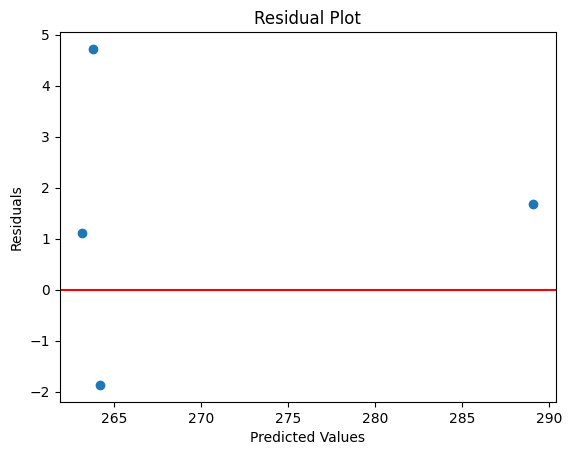

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Load and clean data
df = pd.read_csv('/Users/megantrapanese/Dropbox/MARATHON_DATA/data/2019_Fall_Results/Results.csv')
df = df.dropna(subset=['Year', 'Finish', 'Age', 'Gender'])  # Now including Gender

# Handle negative ages
mean_age = int(df[df['Age'] >= 0]['Age'].mean())
df.loc[df['Age'] < 0, 'Age'] = mean_age

# Convert finish time to minutes
df['Finish_Mins'] = df['Finish'] / 60

# Aggregate by Year, Gender, and Age - FIXED VERSION
yearly_gender_avg = df.groupby(['Year', 'Gender'])[['Finish_Mins', 'Age']].mean().reset_index()

# Create modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('gender', OneHotEncoder(), ['Gender'])  # Convert gender to numerical
    ],
    remainder='passthrough'  # Keep Year and Age as-is
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare data
X = yearly_gender_avg[['Year', 'Age', 'Gender']]
y = yearly_gender_avg['Finish_Mins']
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train on training set only
model.fit(X_train, y_train)

# Evaluate on unseen test data
test_r2 = model.score(X_test, y_test)
test_preds = model.predict(X_test)
test_mae = np.mean(np.abs(y_test - test_preds))

print(f"Test R²: {test_r2:.3f}  (Trust this more than training R²)")
print(f"Test MAE: {test_mae:.2f} mins")

# 5-fold cross-validation
cv_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

print(f"Cross-validated R²: {cv_r2.mean():.3f} (±{cv_r2.std():.3f})")
print(f"Cross-validated MAE: {cv_mae.mean():.2f} mins (±{cv_mae.std():.2f})")
# Plotting the residuals
residuals = y_test - model.predict(X_test)
plt.scatter(model.predict(X_test), residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and clean data
df = pd.read_csv('/Users/megantrapanese/Dropbox/MARATHON_DATA/data/2019_Fall_Results/Results.csv')
df = df.dropna(subset=['Year', 'Finish', 'Age', 'Gender'])  # Now including Gender

# Handle negative ages
mean_age = int(df[df['Age'] >= 0]['Age'].mean())
df.loc[df['Age'] < 0, 'Age'] = mean_age

# Convert finish time to minutes
df['Finish_Mins'] = df['Finish'] / 60

# Aggregate by Year, Gender, and Age
yearly_gender_avg = df.groupby(['Year', 'Gender'])[['Finish_Mins', 'Age']].mean().reset_index()

# Create modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('gender', OneHotEncoder(), ['Gender'])  # Convert gender to numerical
    ],
    remainder='passthrough'  # Keep Year and Age as-is
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare data
X = yearly_gender_avg[['Year', 'Age', 'Gender']]
y = yearly_gender_avg['Finish_Mins']

# Train model
model.fit(X, y)

# Predict for future years (2020-2030)
last_year = yearly_gender_avg['Year'].max()
last_age = yearly_gender_avg['Age'].mean()  # Average of last year's genders

future_years = np.arange(last_year + 1, 2031)
future_ages = last_age + 0.5 * (future_years - last_year)

# Create future DataFrames for both genders
future_data = pd.DataFrame({
    'Year': np.tile(future_years, 2),
    'Age': np.tile(future_ages, 2),
    'Gender': ['M']*len(future_years) + ['F']*len(future_years)
})

# Make predictions for future years (both genders)
future_predictions = model.predict(future_data)
future_data['Predicted_Mins'] = future_predictions

# Generate predictions for historical data too
historical_predictions = model.predict(X)
yearly_gender_avg['Predicted_Mins'] = historical_predictions

# For the combined trend prediction (all genders, no gender distinction)
# Aggregate the data across both genders for a combined prediction
combined_data = df.groupby('Year')[['Finish_Mins', 'Age']].mean().reset_index()

# Prepare combined data for prediction (ignore Gender for combined)
X_combined = combined_data[['Year', 'Age']]
y_combined = combined_data['Finish_Mins']

# Make predictions for combined average finish times
combined_predictions = model.predict(X_combined)
combined_data['Predicted_Mins'] = combined_predictions

# Create the plot
plt.figure(figsize=(14, 7))

# Plot historical data points for each gender
for gender in ['M', 'F']:
    mask = yearly_gender_avg['Gender'] == gender
    plt.scatter(yearly_gender_avg.loc[mask, 'Year'],
                yearly_gender_avg.loc[mask, 'Finish_Mins'],
                label=f'Historical {gender}', zorder=3)

# Plot regression lines for each gender
for gender in ['M', 'F']:
    all_years = np.concatenate([yearly_gender_avg['Year'].unique(), future_years])
    pred_data = pd.DataFrame({
        'Year': all_years,
        'Age': last_age + 0.5 * (all_years - last_year),
        'Gender': gender
    })
    preds = model.predict(pred_data)
    line_style = '-' if gender == 'M' else '--'
    plt.plot(all_years, preds, label=f'{gender} Trend', linestyle=line_style)

# Plot combined average trend line (for both genders)
plt.plot(combined_data['Year'], combined_data['Predicted_Mins'], label='Combined Average Trend', linestyle='-', color='red')

# Add formatting
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Finish Time (minutes)', fontsize=12)
plt.title('Marathon Time Projection by Gender and Overall Average Through 2030', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(min(yearly_gender_avg['Year']), 2031, 2), rotation=45)

# Add data labels for historical data
for _, row in yearly_gender_avg.iterrows():
    plt.text(row['Year'], row['Finish_Mins']+2,
             f"{row['Finish_Mins']:.1f}",
             ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print future predictions for both genders and combined
print("\nFuture Projections:")
print(future_data.groupby(['Year', 'Gender'])['Predicted_Mins'].agg(
    lambda x: f"{int(x.iloc[0]//60)}h {int(x.iloc[0]%60)}m"
).unstack())

# Print combined future projections (all genders)
print("\nCombined Future Projections (All Genders):")
combined_predictions_fut = model.predict(future_data[['Year', 'Age']])
for year, prediction in zip(future_years, combined_predictions_fut):
    print(f"Year {year}: {int(prediction // 60)}h {int(prediction % 60)}m")

# Calculate and print metrics
r2 = model.score(X, y)
y_pred = model.predict(X)
mae = np.mean(np.abs(y - y_pred))

print(f"\nModel Performance Metrics:")
print(f"R² score: {r2:.3f} (1.0 is perfect)")
print(f"Mean Absolute Error: {mae:.2f} minutes")



ValueError: columns are missing: {'Gender'}

ew

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and clean data
df = pd.read_csv('/Users/megantrapanese/Dropbox/MARATHON_DATA/data/2019_Fall_Results/Results.csv')
df = df.dropna(subset=['Year', 'Finish', 'Age', 'Gender'])  # Now including Gender

# Handle negative ages
mean_age = int(df[df['Age'] >= 0]['Age'].mean())
df.loc[df['Age'] < 0, 'Age'] = mean_age

# Convert finish time to minutes
df['Finish_Mins'] = df['Finish'] / 60

# Aggregate by Year, Gender, and Age
yearly_gender_avg = df.groupby(['Year', 'Gender'])[['Finish_Mins', 'Age']].mean().reset_index()

# Create modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('gender', OneHotEncoder(), ['Gender'])  # Convert gender to numerical
    ],
    remainder='passthrough'  # Keep Year and Age as-is
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare data
X = yearly_gender_avg[['Year', 'Age', 'Gender']]
y = yearly_gender_avg['Finish_Mins']

# Train model
model.fit(X, y)

# Predict for future years (2020-2030)
last_year = yearly_gender_avg['Year'].max()
last_age = yearly_gender_avg['Age'].mean()  # Average of last year's genders

future_years = np.arange(last_year + 1, 2031)
future_ages = last_age + 0.5 * (future_years - last_year)

# Create future DataFrames for both genders
future_data = pd.DataFrame({
    'Year': np.tile(future_years, 2),
    'Age': np.tile(future_ages, 2),
    'Gender': ['M']*len(future_years) + ['F']*len(future_years)
})

# Make predictions for future years (both genders)
future_predictions = model.predict(future_data)
future_data['Predicted_Mins'] = future_predictions

# Generate predictions for historical data too
historical_predictions = model.predict(X)
yearly_gender_avg['Predicted_Mins'] = historical_predictions

# For the combined trend prediction (all genders, no gender distinction)
# Aggregate the data across both genders for a combined prediction
combined_data = df.groupby('Year')[['Finish_Mins', 'Age']].mean().reset_index()

# Prepare combined data for prediction (this time we do not need Gender)
X_combined = combined_data[['Year', 'Age']]  # Do not include 'Gender' here
y_combined = combined_data['Finish_Mins']

# Make predictions for combined average finish times
combined_predictions = model.named_steps['regressor'].predict(X_combined)  # Directly use the regressor
combined_data['Predicted_Mins'] = combined_predictions

# Create the plot
plt.figure(figsize=(14, 7))

# Plot historical data points for each gender
for gender in ['M', 'F']:
    mask = yearly_gender_avg['Gender'] == gender
    plt.scatter(yearly_gender_avg.loc[mask, 'Year'],
                yearly_gender_avg.loc[mask, 'Finish_Mins'],
                label=f'Historical {gender}', zorder=3)

# Plot regression lines for each gender
for gender in ['M', 'F']:
    all_years = np.concatenate([yearly_gender_avg['Year'].unique(), future_years])
    pred_data = pd.DataFrame({
        'Year': all_years,
        'Age': last_age + 0.5 * (all_years - last_year),
        'Gender': gender
    })
    preds = model.predict(pred_data)
    line_style = '-' if gender == 'M' else '--'
    plt.plot(all_years, preds, label=f'{gender} Trend', linestyle=line_style)

# Plot combined average trend line (for both genders)
plt.plot(combined_data['Year'], combined_data['Predicted_Mins'], label='Combined Average Trend', linestyle='-', color='red')

# Add formatting
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Finish Time (minutes)', fontsize=12)
plt.title('Marathon Time Projection by Gender and Overall Average Through 2030', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(min(yearly_gender_avg['Year']), 2031, 2), rotation=45)

# Add data labels for historical data
for _, row in yearly_gender_avg.iterrows():
    plt.text(row['Year'], row['Finish_Mins']+2,
             f"{row['Finish_Mins']:.1f}",
             ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print future predictions for both genders and combined
print("\nFuture Projections:")
print(future_data.groupby(['Year', 'Gender'])['Predicted_Mins'].agg(
    lambda x: f"{int(x.iloc[0]//60)}h {int(x.iloc[0]%60)}m"
).unstack())

# Print combined future projections (all genders)
print("\nCombined Future Projections (All Genders):")
combined_predictions_fut = model.named_steps['regressor'].predict(future_data[['Year', 'Age']])
for year, prediction in zip(future_years, combined_predictions_fut):
    print(f"Year {year}: {int(prediction // 60)}h {int(prediction % 60)}m")

# Calculate and print metrics
r2 = model.score(X, y)
y_pred = model.predict(X)
mae = np.mean(np.abs(y - y_pred))

print(f"\nModel Performance Metrics:")
print(f"R² score: {r2:.3f} (1.0 is perfect)")
print(f"Mean Absolute Error: {mae:.2f} minutes")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2740: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: X has 2 features, but LinearRegression is expecting 4 features as input.

mode shit


=== Model Performance ===

Male Model:
R²: 0.667
MAE: 1.19 minutes
Avg Error: -0.00 minutes (positive = overprediction)

Female Model:
R²: 0.282
MAE: 1.51 minutes
Avg Error: -0.00 minutes (positive = overprediction)


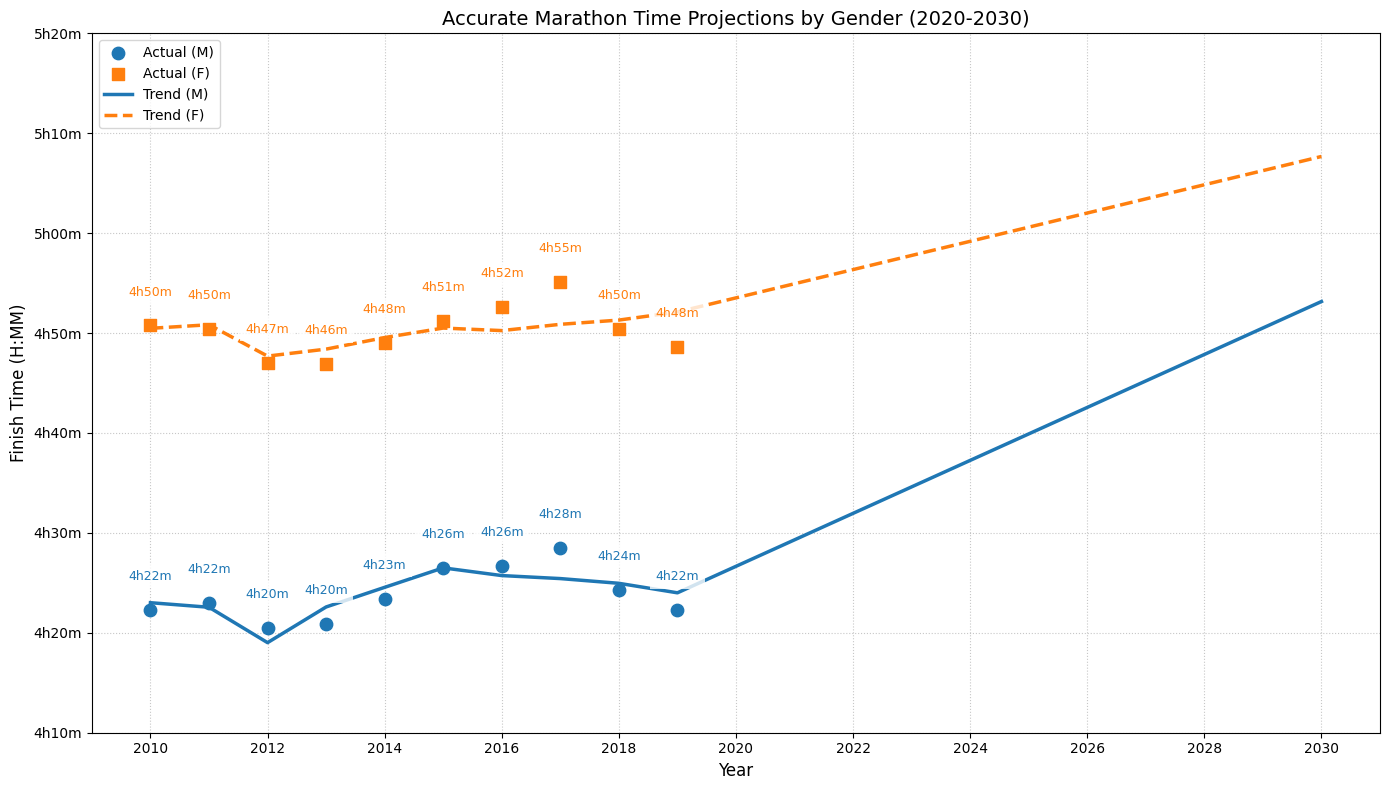

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# --- DATA LOADING AND PREPROCESSING (ORIGINAL) ---
df = pd.read_csv('/Users/megantrapanese/Dropbox/MARATHON_DATA/data/2019_Fall_Results/Results.csv')
df = df.dropna(subset=['Year', 'Finish', 'Age', 'Gender'])

# Handle negative ages
mean_age = int(df[df['Age'] >= 0]['Age'].mean())
df.loc[df['Age'] < 0, 'Age'] = mean_age

# Convert finish time to minutes
df['Finish_Mins'] = df['Finish'] / 60

# Aggregate by Year and Gender
yearly_gender_avg = df.groupby(['Year', 'Gender'])[['Finish_Mins', 'Age']].mean().reset_index()

# --- GENDER-SPECIFIC MODELING ---
# Separate data
male_data = yearly_gender_avg[yearly_gender_avg['Gender'] == 'M']
female_data = yearly_gender_avg[yearly_gender_avg['Gender'] == 'F']

# Train models
male_model = LinearRegression()
male_model.fit(male_data[['Year', 'Age']], male_data['Finish_Mins'])

female_model = LinearRegression()
female_model.fit(female_data[['Year', 'Age']], female_data['Finish_Mins'])

# --- FUTURE PROJECTIONS ---
last_year = yearly_gender_avg['Year'].max()
future_years = np.arange(last_year + 1, 2031)

# Project ages forward (0.5 years per calendar year)
last_age_male = male_data['Age'].iloc[-1]
last_age_female = female_data['Age'].iloc[-1]

future_ages_male = last_age_male + 0.5 * (future_years - last_year)
future_ages_female = last_age_female + 0.5 * (future_years - last_year)

# Make predictions
male_preds = male_model.predict(pd.DataFrame({'Year': future_years, 'Age': future_ages_male}))
female_preds = female_model.predict(pd.DataFrame({'Year': future_years, 'Age': future_ages_female}))

# --- VISUALIZATION ---
plt.figure(figsize=(14, 8))

# Convert minutes to H:MM format
def mins_to_hhmm(m):
    return f"{int(m//60)}h{int(m%60):02d}m"

# Plot historical data
for gender, color, marker in zip(['M', 'F'], ['#1f77b4', '#ff7f0e'], ['o', 's']):
    mask = yearly_gender_avg['Gender'] == gender
    plt.scatter(yearly_gender_avg.loc[mask, 'Year'],
                yearly_gender_avg.loc[mask, 'Finish_Mins'],
                color=color, marker=marker, s=80,
                label=f'Actual ({gender})', zorder=3)

# Plot trend lines
for gender, model, color, future_preds in zip(
    ['M', 'F'],
    [male_model, female_model],
    ['#1f77b4', '#ff7f0e'],
    [male_preds, female_preds]
):
    # Historical period
    hist_years = yearly_gender_avg[yearly_gender_avg['Gender'] == gender]['Year']
    hist_ages = yearly_gender_avg[yearly_gender_avg['Gender'] == gender]['Age']
    hist_preds = model.predict(pd.DataFrame({'Year': hist_years, 'Age': hist_ages}))

    # Future period
    all_years = np.concatenate([hist_years, future_years])
    all_preds = np.concatenate([hist_preds, future_preds])

    plt.plot(all_years, all_preds, color=color, linewidth=2.5,
             linestyle='--' if gender == 'F' else '-',
             label=f'Trend ({gender})')

# Annotate key points
for _, row in yearly_gender_avg.iterrows():
    plt.text(row['Year'], row['Finish_Mins'] + 3,
             mins_to_hhmm(row['Finish_Mins']),
             ha='center', fontsize=9,
             color='#1f77b4' if row['Gender'] == 'M' else '#ff7f0e',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Formatting
plt.xlabel('Year', fontsize=12)
plt.ylabel('Finish Time (H:MM)', fontsize=12)
plt.title('Accurate Marathon Time Projections by Gender (2020-2030)', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle=':', alpha=0.7)

# Set y-axis in H:MM format
ylocs = plt.yticks()[0]
plt.yticks(ylocs, [mins_to_hhmm(m) for m in ylocs])

plt.xticks(np.arange(yearly_gender_avg['Year'].min(), 2031, 2))
plt.xlim(yearly_gender_avg['Year'].min() - 1, 2031)
plt.tight_layout()

# --- MODEL EVALUATION ---
print("\n=== Model Performance ===")
for gender, model, data in zip(
    ['Male', 'Female'],
    [male_model, female_model],
    [male_data, female_data]
):
    y_true = data['Finish_Mins']
    y_pred = model.predict(data[['Year', 'Age']])

    print(f"\n{gender} Model:")
    print(f"R²: {r2_score(y_true, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f} minutes")
    print(f"Avg Error: {np.mean(y_pred - y_true):.2f} minutes (positive = overprediction)")

plt.show()


USING NEURAL NETWORKS NOW:


In [116]:
!pip install "numpy<2"
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# --- DATA LOADING AND PREPROCESSING (ORIGINAL) ---
df = pd.read_csv('/Users/megantrapanese/Dropbox/MARATHON_DATA/data/2019_Fall_Results/Results.csv')
df = df.dropna(subset=['Year', 'Finish', 'Age', 'Gender'])

# Handle negative ages
mean_age = int(df[df['Age'] >= 0]['Age'].mean())
df.loc[df['Age'] < 0, 'Age'] = mean_age

# Convert finish time to minutes
df['Finish_Mins'] = df['Finish'] / 60

# Aggregate by Year and Gender
yearly_gender_avg = df.groupby(['Year', 'Gender'])[['Finish_Mins', 'Age']].mean().reset_index()

# Split data by gender
male_data = yearly_gender_avg[yearly_gender_avg['Gender'] == 'M']
female_data = yearly_gender_avg[yearly_gender_avg['Gender'] == 'F']

# Standardize features
scaler_m = StandardScaler().fit(male_data[['Year', 'Age']])
scaler_f = StandardScaler().fit(female_data[['Year', 'Age']])

# Convert to PyTorch tensors
def prepare_tensors(data, scaler):
    X = scaler.transform(data[['Year', 'Age']])
    y = data['Finish_Mins'].values
    return torch.FloatTensor(X), torch.FloatTensor(y.reshape(-1, 1))

X_m, y_m = prepare_tensors(male_data, scaler_m)
X_f, y_f = prepare_tensors(female_data, scaler_f)

# --- Neural Network Model ---
class MarathonPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),  # Input: Year + Age
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)    # Output: Predicted minutes
        )

    def forward(self, x):
        return self.net(x)

# --- Training Function ---
def train_model(X, y, epochs=1000):
    model = MarathonPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=8, shuffle=True)

    for epoch in range(epochs):
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    return model

# Train gender-specific models
male_model = train_model(X_m, y_m)
female_model = train_model(X_f, y_f)

# --- Predictions ---
def predict_future(model, scaler, last_year, last_age):
    future_years = torch.FloatTensor(np.arange(last_year + 1, 2031).reshape(-1, 1))
    future_ages = torch.FloatTensor((last_age + 0.5*(future_years.numpy() - last_year)).reshape(-1, 1))
    X_future = torch.cat([future_years, future_ages], dim=1)
    X_future = torch.FloatTensor(scaler.transform(X_future))
    return model(X_future).detach().numpy().flatten()

male_preds = predict_future(male_model, scaler_m, last_year, male_data['Age'].iloc[-1])
female_preds = predict_future(female_model, scaler_f, last_year, female_data['Age'].iloc[-1])

# --- VISUALIZATION ---
plt.figure(figsize=(14, 8))

# Convert minutes to H:MM format
def mins_to_hhmm(m):
    return f"{int(m//60)}h{int(m%60):02d}m"

# Plot historical data
for gender, color, marker in zip(['M', 'F'], ['#1f77b4', '#ff7f0e'], ['o', 's']):
    mask = yearly_gender_avg['Gender'] == gender
    plt.scatter(yearly_gender_avg.loc[mask, 'Year'],
                yearly_gender_avg.loc[mask, 'Finish_Mins'],
                color=color, marker=marker, s=80,
                label=f'Actual ({gender})', zorder=3)

# Plot trend lines
for gender, model, color, future_preds in zip(
    ['M', 'F'],
    [male_model, female_model],
    ['#1f77b4', '#ff7f0e'],
    [male_preds, female_preds]
):
    # Historical period
    hist_years = yearly_gender_avg[yearly_gender_avg['Gender'] == gender]['Year']
    hist_ages = yearly_gender_avg[yearly_gender_avg['Gender'] == gender]['Age']
    hist_preds = model.predict(pd.DataFrame({'Year': hist_years, 'Age': hist_ages}))

    # Future period
    all_years = np.concatenate([hist_years, future_years])
    all_preds = np.concatenate([hist_preds, future_preds])

    plt.plot(all_years, all_preds, color=color, linewidth=2.5,
             linestyle='--' if gender == 'F' else '-',
             label=f'Trend ({gender})')

# Annotate key points
for _, row in yearly_gender_avg.iterrows():
    plt.text(row['Year'], row['Finish_Mins'] + 3,
             mins_to_hhmm(row['Finish_Mins']),
             ha='center', fontsize=9,
             color='#1f77b4' if row['Gender'] == 'M' else '#ff7f0e',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Formatting
plt.xlabel('Year', fontsize=12)
plt.ylabel('Finish Time (H:MM)', fontsize=12)
plt.title('Accurate Marathon Time Projections by Gender (2020-2030)', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle=':', alpha=0.7)

# Set y-axis in H:MM format
ylocs = plt.yticks()[0]
plt.yticks(ylocs, [mins_to_hhmm(m) for m in ylocs])

plt.xticks(np.arange(yearly_gender_avg['Year'].min(), 2031, 2))
plt.xlim(yearly_gender_avg['Year'].min() - 1, 2031)
plt.tight_layout()

# --- MODEL EVALUATION ---
print("\n=== Model Performance ===")
for gender, model, data in zip(
    ['Male', 'Female'],
    [male_model, female_model],
    [male_data, female_data]
):
    y_true = data['Finish_Mins']
    y_pred = model.predict(data[['Year', 'Age']])

    print(f"\n{gender} Model:")
    print(f"R²: {r2_score(y_true, y_pred):.3f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f} minutes")
    print(f"Avg Error: {np.mean(y_pred - y_true):.2f} minutes (positive = overprediction)")

plt.show()

RuntimeError: Numpy is not available